In [36]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [37]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [38]:

# Download the data using yfinance.
data = yf.download('GC=F', start='2021-01-01', end='2024-11-01')
data.columns = data.columns.get_level_values(0)  
data = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)



[*********************100%***********************]  1 of 1 completed


In [39]:

# Parameters
seq_length = 60  # 60 days of historical data

# Prepare data with sliding window
X, y = create_sequences(data_normalized, seq_length)

# Split data for LSTM, Scoring, and Fine-tuning
lstm_split = int(0.5 * len(X))
scoring_split = int(0.75 * len(X))

X_lstm, y_lstm = X[:lstm_split], y[:lstm_split]
X_scoring, y_scoring = X[lstm_split:scoring_split], y[lstm_split:scoring_split]
X_finetuning, y_finetuning = X[scoring_split:], y[scoring_split:]

# Further split LSTM data into train and test
lstm_train_split = int(0.8 * len(X_lstm))
X_lstm_train, y_lstm_train = X_lstm[:lstm_train_split], y_lstm[:lstm_train_split]
X_lstm_test, y_lstm_test = X_lstm[lstm_train_split:], y_lstm[lstm_train_split:]



In [ ]:
# LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, fc1_size=25, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, fc1_size)  # Dense layer with 25 neurons
        self.fc2 = nn.Linear(fc1_size, output_size)  # Output layer with 1 neuron

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM layers
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        
        # Take the last timestep's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Pass through fully connected layers
        out = self.fc1(out)  # Shape: (batch_size, fc1_size)
        out = torch.relu(out)  # Apply activation function
        out = self.fc2(out)  # Shape: (batch_size, output_size)
        return out


lstm_model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)



In [41]:
# Train LSTM model
def train_model(model, train_data, train_targets, epochs=50, batch_size=32):
    train_data = torch.FloatTensor(train_data).to(device)
    train_targets = torch.FloatTensor(train_targets).to(device)
    train_dataset = TensorDataset(train_data, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(lstm_model, X_lstm_train, y_lstm_train)




Epoch [10/50], Loss: 0.0005
Epoch [20/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0003
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0002


In [42]:
# LSTM Predictions and Evaluation
def predict_and_evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        X = torch.FloatTensor(X).to(device)
        predictions = model(X).cpu().numpy()

    y = scaler.inverse_transform(y.reshape(-1, 1))
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    mae = np.mean(np.abs(y - predictions))
    mape = np.mean(np.abs((y - predictions) / y)) * 100

    return predictions, mae, mape

lstm_train_preds, lstm_train_mae, lstm_train_mape = predict_and_evaluate(lstm_model, X_lstm_train, y_lstm_train)
lstm_test_preds, lstm_test_mae, lstm_test_mape = predict_and_evaluate(lstm_model, X_lstm_test, y_lstm_test)

print(f"LSTM Train MAE: {lstm_train_mae:.2f}, MAPE: {lstm_train_mape:.2f}%")
print(f"LSTM Test MAE: {lstm_test_mae:.2f}, MAPE: {lstm_test_mape:.2f}%")


LSTM Train MAE: 12.68, MAPE: 0.70%
LSTM Test MAE: 25.29, MAPE: 1.49%


In [43]:

# Scoring Model
class ScoringModel(nn.Module):
    def __init__(self, input_size=seq_length+1, hidden_size=32, output_size=1):
        super(ScoringModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(out))
        return out

scoring_model = ScoringModel().to(device)
scoring_criterion = nn.MSELoss()
scoring_optimizer = optim.Adam(scoring_model.parameters(), lr=0.001)



In [44]:
# Prepare scoring data
def prepare_scoring_data(X, y):
    lstm_model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        predictions = lstm_model(X_tensor).cpu().numpy()

    scoring_X = np.concatenate([X.reshape(X.shape[0], -1), predictions], axis=1)
    scoring_y = np.abs(y - predictions.reshape(-1, 1))  # Use absolute error as the score
    return scoring_X, scoring_y

X_scoring_train, y_scoring_train = prepare_scoring_data(X_scoring[:int(0.8*len(X_scoring))], y_scoring[:int(0.8*len(X_scoring))])
X_scoring_test, y_scoring_test = prepare_scoring_data(X_scoring[int(0.8*len(X_scoring)):], y_scoring[int(0.8*len(X_scoring)):])

# Train scoring model
train_model(scoring_model, X_scoring_train, y_scoring_train, epochs=30)




Epoch [10/30], Loss: 0.2129
Epoch [20/30], Loss: 0.2131
Epoch [30/30], Loss: 0.2117


In [45]:

# Fine-tuning function
def fine_tune_lstm(lstm_model, scoring_model, X, y, epochs=10, lr=0.0001):
    fine_tune_optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    for epoch in range(epochs):
        lstm_model.train()
        total_loss = 0
        for i in range(len(X)):
            fine_tune_optimizer.zero_grad()
            lstm_output = lstm_model(X_tensor[i].unsqueeze(0))
            loss = criterion(lstm_output, y_tensor[i].unsqueeze(0))

            # Get score from scoring model
            scoring_input = torch.cat([X_tensor[i].reshape(1, -1), lstm_output.detach()], dim=1)
            score = scoring_model(scoring_input)

            # Adjust loss based on score
            adjusted_loss = loss * (1 + score.item())
            adjusted_loss.backward()
            fine_tune_optimizer.step()
            total_loss += adjusted_loss.item()

        if (epoch + 1) % 5 == 0:
            print(f'Fine-tuning Epoch [{epoch+1}/{epochs}], Avg Loss: {total_loss/len(X):.4f}')

# Split fine-tuning data
X_finetune_train, y_finetune_train = X_finetuning[:int(0.8*len(X_finetuning))], y_finetuning[:int(0.8*len(X_finetuning))]
X_finetune_test, y_finetune_test = X_finetuning[int(0.8*len(X_finetuning)):], y_finetuning[int(0.8*len(X_finetuning)):]



In [46]:
# Predictions with original LSTM on fine-tuning dataset
original_finetune_train_preds, original_finetune_train_mae, original_finetune_train_mape = predict_and_evaluate(lstm_model, X_finetune_train, y_finetune_train)
original_finetune_test_preds, original_finetune_test_mae, original_finetune_test_mape = predict_and_evaluate(lstm_model, X_finetune_test, y_finetune_test)

print("\nOriginal LSTM on Fine-tuning Dataset:")
print(f"Train MAE: {original_finetune_train_mae:.2f}, MAPE: {original_finetune_train_mape:.2f}%")
print(f"Test MAE: {original_finetune_test_mae:.2f}, MAPE: {original_finetune_test_mape:.2f}%")




Original LSTM on Fine-tuning Dataset:
Train MAE: 134.09, MAPE: 5.77%
Test MAE: 174.97, MAPE: 6.70%


In [47]:
# Fine-tune LSTM
fine_tune_lstm(lstm_model, scoring_model, X_finetune_train, y_finetune_train)

# Evaluate fine-tuned model
finetuned_train_preds, finetuned_train_mae, finetuned_train_mape = predict_and_evaluate(lstm_model, X_finetune_train, y_finetune_train)
finetuned_test_preds, finetuned_test_mae, finetuned_test_mape = predict_and_evaluate(lstm_model, X_finetune_test, y_finetune_test)

print("\nFine-tuned LSTM on Fine-tuning Dataset:")
print(f"Train MAE: {finetuned_train_mae:.2f}, MAPE: {finetuned_train_mape:.2f}%")
print(f"Test MAE: {finetuned_test_mae:.2f}, MAPE: {finetuned_test_mape:.2f}%")



Fine-tuning Epoch [5/10], Avg Loss: 0.0009
Fine-tuning Epoch [10/10], Avg Loss: 0.0009

Fine-tuned LSTM on Fine-tuning Dataset:
Train MAE: 57.97, MAPE: 2.66%
Test MAE: 25.32, MAPE: 0.96%


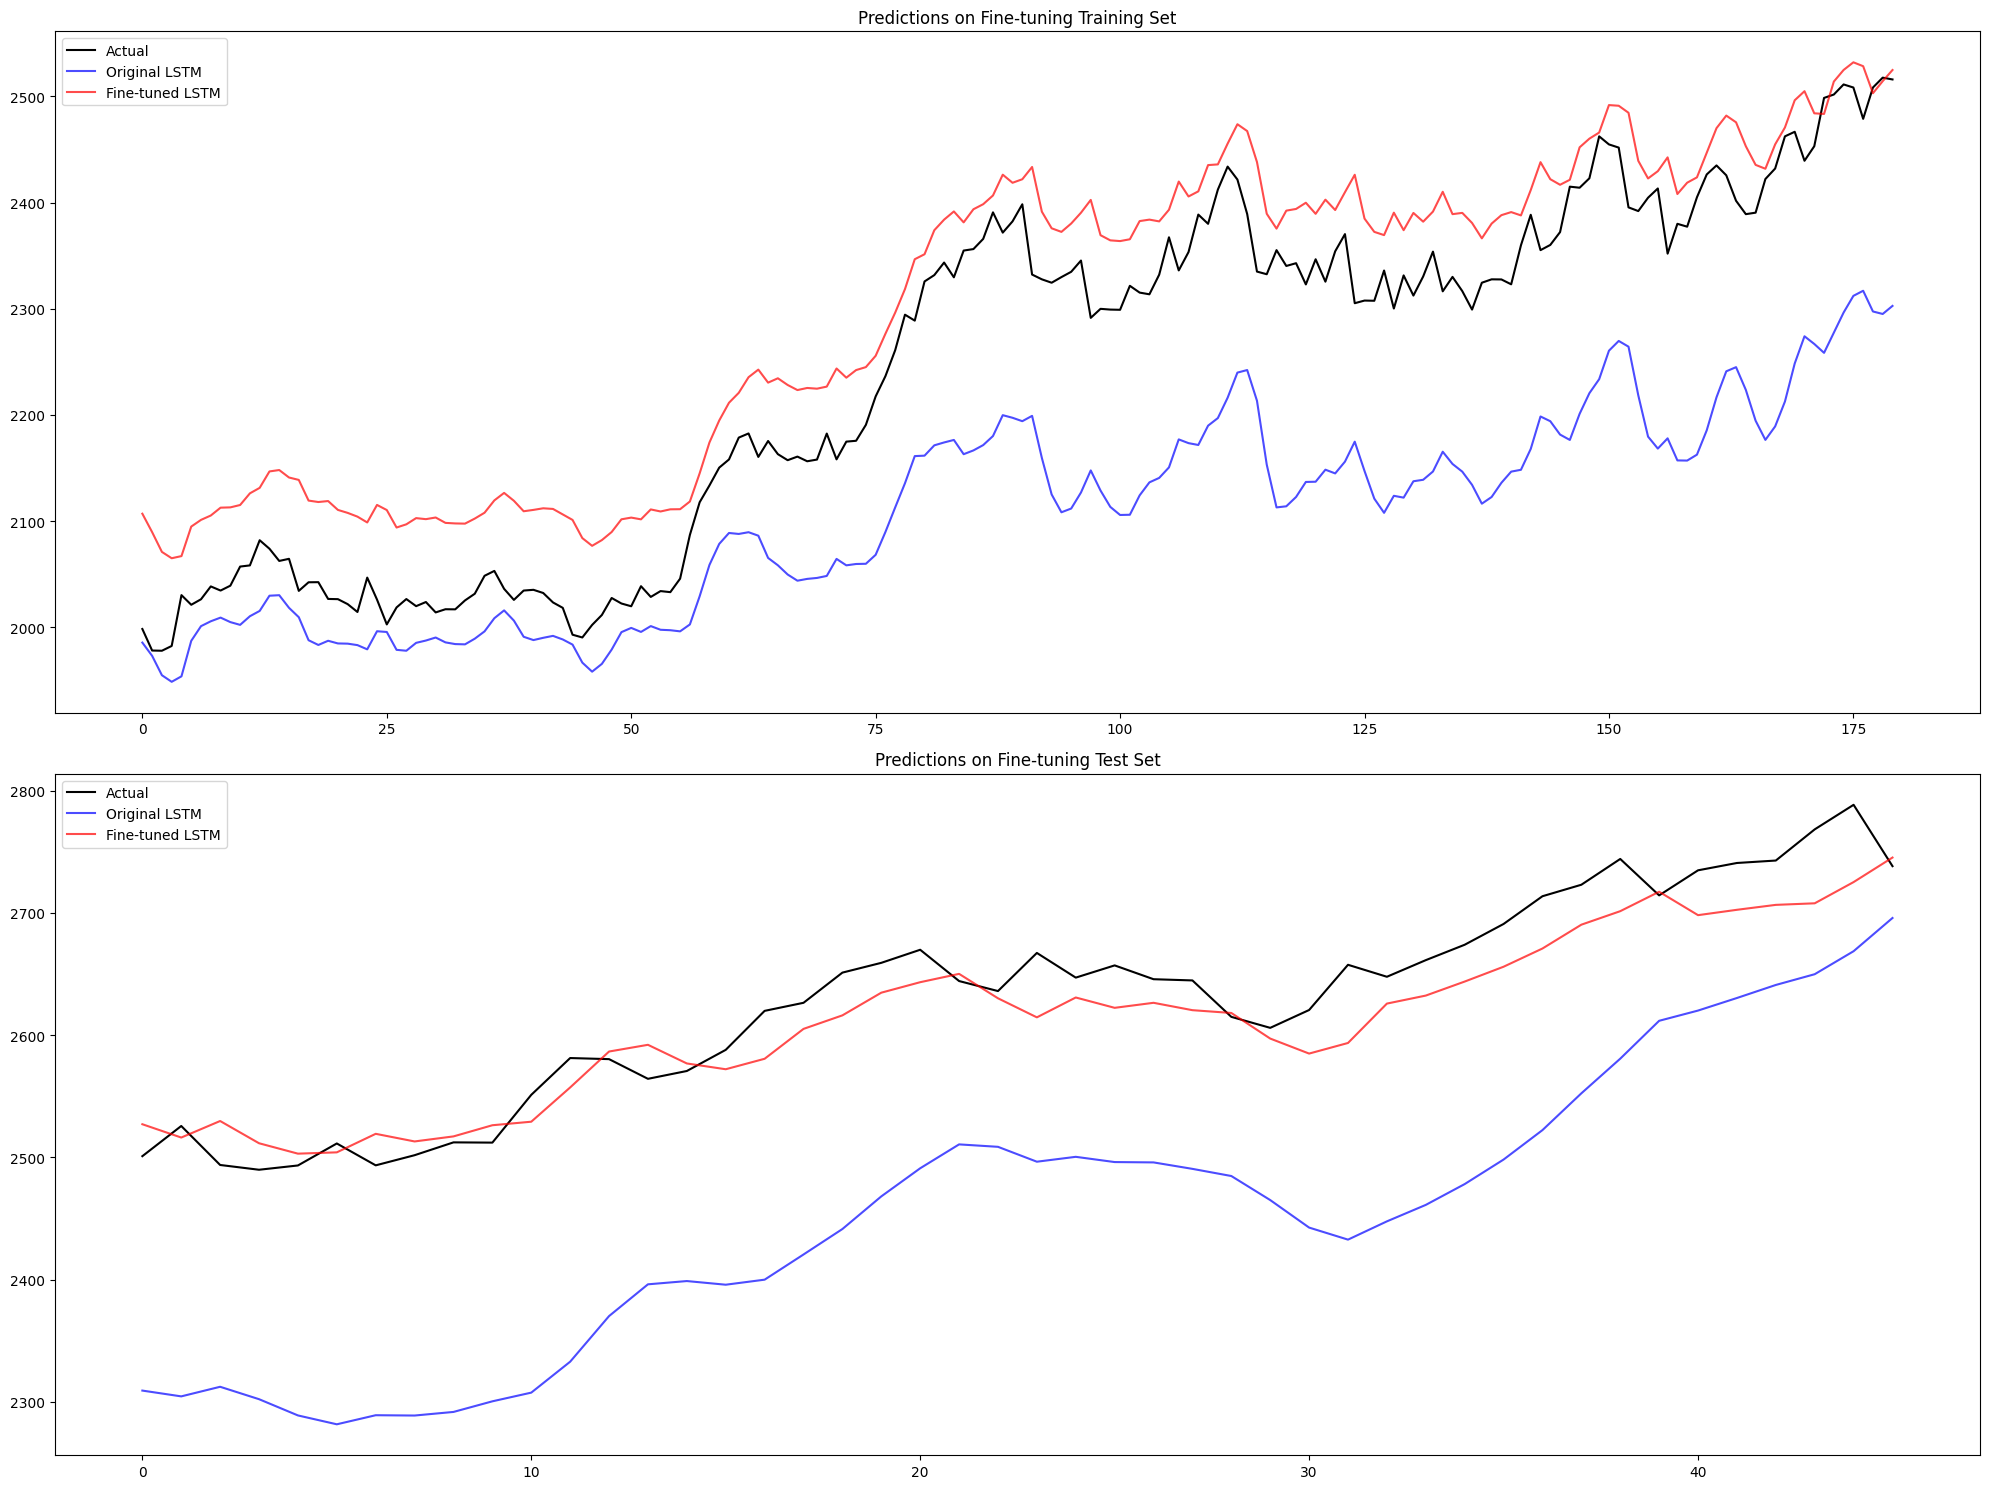


Improvement after Fine-tuning:
Train MAE Improvement: 56.77%
Train MAPE Improvement: 53.99%
Test MAE Improvement: 85.53%
Test MAPE Improvement: 85.74%


In [48]:
# Plot results
plt.figure(figsize=(20, 15))

# Training set comparison
plt.subplot(2, 1, 1)
plt.plot(scaler.inverse_transform(y_finetune_train), label='Actual', color='black')
plt.plot(original_finetune_train_preds, label='Original LSTM', color='blue', alpha=0.7)
plt.plot(finetuned_train_preds, label='Fine-tuned LSTM', color='red', alpha=0.7)
plt.title('Predictions on Fine-tuning Training Set')
plt.legend()

# Test set comparison
plt.subplot(2, 1, 2)
plt.plot(scaler.inverse_transform(y_finetune_test), label='Actual', color='black')
plt.plot(original_finetune_test_preds, label='Original LSTM', color='blue', alpha=0.7)
plt.plot(finetuned_test_preds, label='Fine-tuned LSTM', color='red', alpha=0.7)
plt.title('Predictions on Fine-tuning Test Set')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate improvement percentages
train_mae_improvement = (original_finetune_train_mae - finetuned_train_mae) / original_finetune_train_mae * 100
train_mape_improvement = (original_finetune_train_mape - finetuned_train_mape) / original_finetune_train_mape * 100
test_mae_improvement = (original_finetune_test_mae - finetuned_test_mae) / original_finetune_test_mae * 100
test_mape_improvement = (original_finetune_test_mape - finetuned_test_mape) / original_finetune_test_mape * 100

print("\nImprovement after Fine-tuning:")
print(f"Train MAE Improvement: {train_mae_improvement:.2f}%")
print(f"Train MAPE Improvement: {train_mape_improvement:.2f}%")
print(f"Test MAE Improvement: {test_mae_improvement:.2f}%")
print(f"Test MAPE Improvement: {test_mape_improvement:.2f}%")